# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import math
from pathlib import Path
import os
from datetime import datetime
from shapely.geometry import Point
from src.datasources import codab, rsmc
from src import constants

In [3]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

<Axes: >

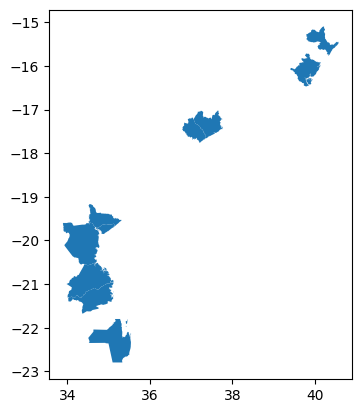

In [4]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
ADMS2 = constants.ADMS2
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)
gdf_adm2_sel = gdf_adm2[gdf_adm2.ADM2_PT.isin(ADMS2)]
gdf_adm2_sel.plot()

<Axes: >

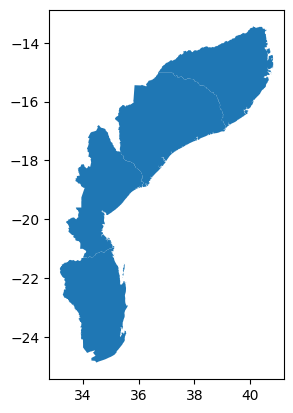

In [5]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [6]:
adm2_setting = False
if adm2_setting:
    adm = gdf_adm2_sel.copy()

In [7]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [8]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)
cyclone_tracks_buffer = cyclone_tracks.copy()
cyclone_tracks_buffer["RMW_km"] = cyclone_tracks_buffer["RMW (mn)"] * 1.852

In [9]:
cyclone_tracks_buffer["RMW_km"] = (
    cyclone_tracks_buffer["RMW_km"].fillna(0.001).replace(0, 0.001)
)

In [11]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_buffer["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf_buffer = gpd.GeoDataFrame(
    cyclone_tracks_buffer, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_gdf_buffer["geometry"] = (
    cyclone_tracks_gdf_buffer.geometry.buffer(
        cyclone_tracks_gdf_buffer["RMW_km"] / 110.574
    )
)

C:\Users\pauni\AppData\Local\Temp\ipykernel_29604\3989432146.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cyclone_tracks_gdf_buffer.geometry.buffer(


In [12]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel_adm2 = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm2_sel, how="inner", predicate="intersects"
)
cyclone_tracks_sel_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel_adm2_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer,
    gdf_adm2_sel,
    how="inner",
    predicate="intersects",
)

<Axes: >

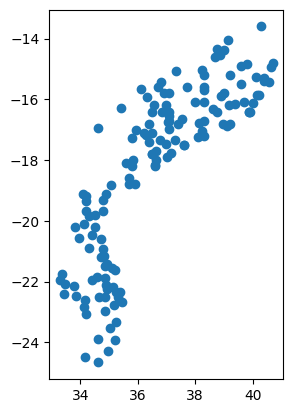

In [13]:
cyclone_tracks_sel.plot()

<Axes: >

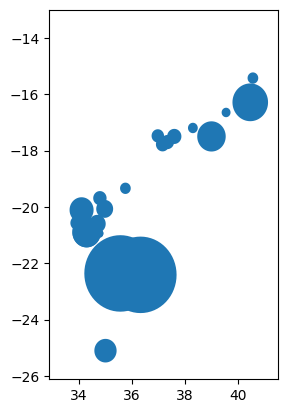

In [14]:
cyclone_tracks_sel_buffer.plot()

<Axes: >

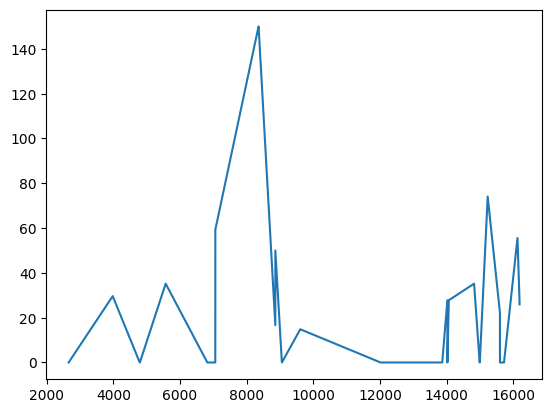

In [15]:
cyclone_tracks_sel_adm2_buffer["RMW_km"].plot()

In [16]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [17]:
def calculate_storm_return_period_la_reunion(
    df, wind_speed_kmh, start_year, num_storms_year
):

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["Max wind (kt)"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each administrative region
    # admin_return_periods = {}

    # grouped = df_filtered.groupby("ADM1_PT")
    # for admin, group in grouped:
    #    admin_unique_storms = group["Name"].nunique()
    #    admin_return_period = yr_len / admin_unique_storms
    #    admin_return_periods[admin] = admin_return_period

    #    print(
    #        f"The return period of storms over {wind_speed_kmh} km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
    #    )

    # Calculate probabilities using the Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"The probability of exactly {num_storms_year} storms making landfall in an average year is {round(expected_probability * 100, 1)}%."
    )
    print(
        f"The return period of exactly {num_storms_year} storms making landfall in an average year is 1-in-{round(1 / expected_probability, 1)} years."
    )

In [18]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-3.4 years.
The probability of exactly 1 storms making landfall in an average year is 22.0%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.5 years.


In [19]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-5.5 years.
The probability of exactly 1 storms making landfall in an average year is 15.2%.
The return period of exactly 1 storms making landfall in an average year is 1-in-6.6 years.


In [20]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-4.0 years.
The probability of exactly 1 storms making landfall in an average year is 19.5%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.1 years.


In [21]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-7.3 years.
The probability of exactly 1 storms making landfall in an average year is 11.9%.
The return period of exactly 1 storms making landfall in an average year is 1-in-8.4 years.


With Buffer

In [22]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_buffer,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-3.1 years.
The probability of exactly 1 storms making landfall in an average year is 23.1%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.3 years.


In [23]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2_buffer,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-4.4 years.
The probability of exactly 1 storms making landfall in an average year is 18.1%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.5 years.


In [24]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_buffer,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-4.0 years.
The probability of exactly 1 storms making landfall in an average year is 19.5%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.1 years.


In [25]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2_buffer,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-6.3 years.
The probability of exactly 1 storms making landfall in an average year is 13.6%.
The return period of exactly 1 storms making landfall in an average year is 1-in-7.4 years.
